In [25]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir
from bisect import bisect_left


In [26]:
def shift_correct(input_pos,idx):
    output_pos = np.insert(input_pos,0,np.linspace(0,0,idx))
    return output_pos

def gaussian(data_x,params=list):
    norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
    return params[0] * norm * np.exp(-(np.subtract(data_x,params[1])**2/(2*params[2]**2)))+params[3]

def gaussian_cdf(data_x,params=list):
    # for normalization a 1/sigma could be needed
    return params[0]*0.5*(1+scipy.special.erf((data_x-params[1])/(np.sqrt(2)*params[2])))+params[3]

def linear(data_x,params=list):
    return params[0]*data_x+params[1]

def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
    chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevalue, ndf)

def chisquare_linear(a,b):
    return chisquare_1d(function=linear,functionparams=[a,b],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def chisquare_gaussian(area,mean,sigma,constant):
    return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def chisquare_gaussian_cdf(amp,mean,sigma,constant):
    return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

In [217]:

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before


------------------------------------------------------------------
| FCN = 1.815                   |      Ncalls=35 (35 total)      |
| EDM = 1.22E-11 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0.019834000085488412 -0.0015000315197539749


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
  # This is added back by InteractiveShellApp.init_path()


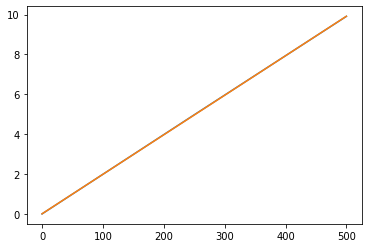

In [207]:
pos_list=np.asarray([-0.007,4.968,9.91])
y_err=np.asarray([0.01,0.01,0.01])
val = np.asarray([0,250,500])
data_x=val
data_y=pos_list
data_y_error=y_err
m2=Minuit(chisquare_linear, 
     a = 100,
     b=0,
     errordef = 1,
     print_level=1)

m2.migrad()

print(m2.values["a"],m2.values["b"])
plt.plot(val,pos_list)
plt.plot(val,m2.values["a"]*val+m2.values["b"])

In [208]:
# calibration of the voltage - position conversion

def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

In [209]:
# load the data
Day = "12"
Month = "11"
Year = "2019"
BeadNumber = 1
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/Bead"+str(BeadNumber)+"/Shaking/"
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/NoBead"+"/Shaking/"
files = load_dir(folder, file_prefix = 'BeamProfile', max_file=500)
pos_x = files[0].cant_pos[0]
pos_y = files[0].cant_pos[1]
pos_z = files[0].cant_pos[2]
quad_sum = files[0].quad_sum


11  files in folder
11  files loaded


In [210]:
for i in np.arange(0,len(files),1):
    print(files[i].fname)

/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile10_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile11_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile1_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile2_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile3_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile4_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile5_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile6_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile7_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile8_0.h5
/home/data_transfer/data_from_windows/20191112/Bead1/Shaking/BeamProfile9_0.h5


In [254]:
def fwhm_estimate(files,sf,quantile_low,quantile_up):
    max_val = files[sf].quad_sum[np.argmax(files[sf].cant_pos[0])]
    min_val = np.min(files[sf].quad_sum)
    closest_upper = take_closest(files[sf].quad_sum,(max_val+min_val)/2*quantile_up)
    closest_lower = take_closest(files[sf].quad_sum,(max_val+min_val)/2*quantile_low)
    index_upper = list(files[sf].quad_sum).index(closest_upper)
    index_lower = list(files[sf].quad_sum).index(closest_lower) 
    pos_upper = files[sf].cant_pos[0][index_upper]
    pos_lower = files[sf].cant_pos[0][index_lower]
    #print((max_val+min_val)/2*quantile_low)
    #print(max_val,min_val,closest_upper,closest_lower)
    print(closest_upper/(max_val))
    return pos_upper,pos_lower

In [255]:
files[10].quad_sum[np.argmin(files[10].quad_sum-285189965.5)]

32729202

In [256]:
Beam profile 6 1.5 V amplitude x position was 10 V

Beam profiling 7 x is -20 V

Beam profiling 8 40 V

Beam profile 9 70 V

Beam profile 10 70 V, 2 V amp

Beam profile 11 100 V

SyntaxError: invalid syntax (<ipython-input-256-0c6c0c6bde8c>, line 1)

In [257]:
# get shield files
shield_files = [0,1,7,8,9,10]
voltage_list =[70,100,10,-20,40,70]

In [267]:
#Beam Profile for X
def get_average_mean_position(file_list):
    position_list = []
    diff_list = []
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    counter =0
    for i in shield_files:#len(file_list),1):
        data_x = file_list[i].cant_pos[0] # give x data
        data_y = file_list[i].quad_sum# give y data 
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
        up,low = fwhm_estimate(file_list,i,0.5,1.5)
        diff_list.append(up-low)
        print(up,low,up-low)
        print(voltage_list[counter])
        counter +=1
        plt.plot(data_x,data_y)
        plt.axvline(up,color="r")
        plt.axvline(low,color='r')
        plt.axhline(data_y[np.argmax(data_x)])
        #plt.axvline(data_x[list(data_y).index(take_closest(data_y,np.median(data_y)))],color="r")
        #plt.plot(data_x,gaussian_cdf(data_x,params=[m.values["amp"],(m.values["mean"]),m.values["sigma"],m.values["constant"]]),alpha=1)
        #plt.axvline(30095)
        #plt.yscale("log")
        plt.show() 
    return diff_list


0.7544536667652719
3.113160157733388 1.829997027677691 1.283163130055697
70


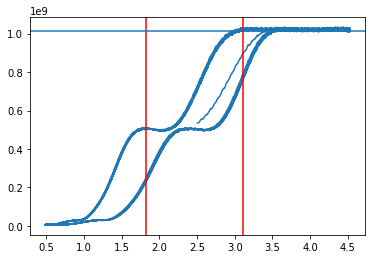

0.7537517055738501
3.2349298612486215 1.7873823238592703 1.4475475373893512
100


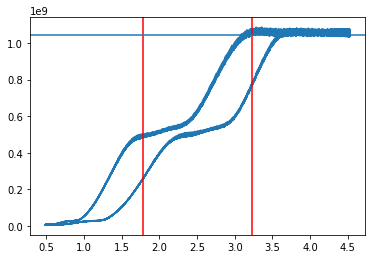

0.7564010167388799
2.6800855430740804 1.990402076700664 0.6896834663734164
10


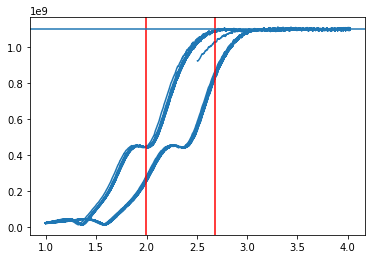

0.7600794505409605
2.5930135890474637 2.4081046699309305 0.18490891911653318
-20


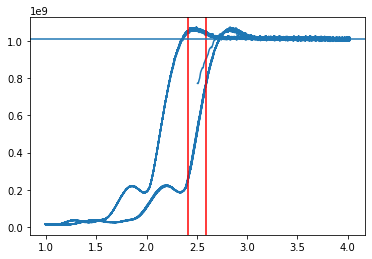

0.7713694612532467
2.856013320989513 1.836459428645373 1.01955389234414
40


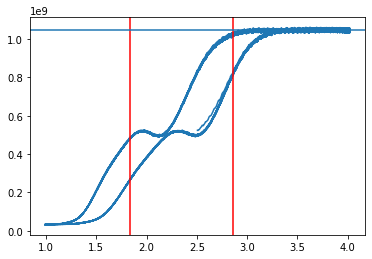

0.7716801618106849
3.0401997356772883 2.50654918039065 0.5336505552866382
70


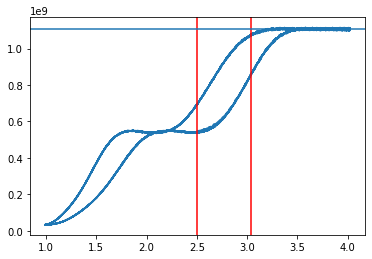

In [268]:
test = get_average_mean_position(files)

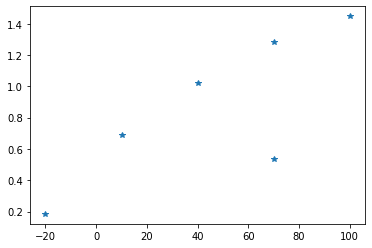

In [269]:
plt.plot(voltage_list,test,linestyle="",marker="*")

In [161]:
print(m.values[2:3])

NameError: name 'm' is not defined

In [178]:
#Beam Profile for Y
def get_average_mean_position(file_list):
    position_list = []
    
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    
    for i in np.arange(0,len(file_list),1):#len(file_list),1):
        print(i)
        data_x = file_list[i].cant_pos[1] # give x data
        data_y = file_list[i].quad_sum# give y data 
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
        m=Minuit(chisquare_gaussian_cdf, 
         amp = 1.8e9, # set start parameter
         #limit_area= (limit_lower,limit_upper) # if you want to limit things
         #limit_amp = (-3e-9,-1.5e-9), # you can also fix it
         mean = 8.6,
         #fix_mean = "True",
         #limit_mean = (3500,4500),
         sigma = 0.3e-1,
         constant = 1.0e9,
         #fix_constant="True",
         errordef = 1,
         print_level=0,pedantic=False)
         #print('Now proceed with the fit.')
        m.migrad(ncall=500000)
        print(m.values["amp"])
        position_list.append(voltage_to_position(m.values["mean"]))
        plt.plot(voltage_to_position(data_x),data_y)
        plt.plot(voltage_to_position(data_x),gaussian_cdf(data_x,params=[m.values["amp"],(m.values["mean"]),m.values["sigma"],m.values["constant"]]))
        plt.show() 
    return position_list,np.mean(position_list),np.std(position_list)


0
1019778646.1904231


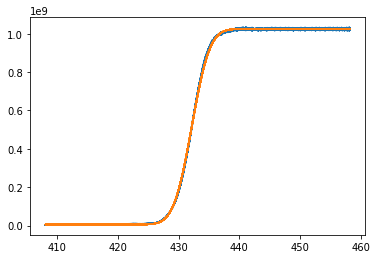

([432.1514113913097], 432.1514113913097, 0.0)

In [179]:
get_average_mean_position(files[2:3])